In [1]:
# Importando bibliotecas necessárias para a construção de grafos
import netpixi
from netpixi.integration.gt import *
from regression.integration.gt import *
import pandas as pd
import numpy as np
import csv
import ast
import cpnet
from graph_tool import spectral
import seaborn as sns
import regression as reg

from scipy import stats
from matplotlib import pyplot as plt

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/usr/local/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/site-packages/seaborn/cm.py:1582: PendingDeprecationWarning: The register_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register_cmap(_name, _cmap)
/usr/local/lib/python3.10/site-packages/seaborn/cm.py:1583: PendingDeprecationWarning: The register_cmap function will b

In [2]:
df = pd.read_csv('./Video_Games_Sales_as_at_22_Dec_2016.csv')
df.dropna(subset=['Publisher'], inplace=True)
df = df.loc[~df['Critic_Score'].isna() & ~df['User_Score'].isna() & ~df['Rating'].isna()]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6943 entries, 0 to 16706
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6943 non-null   object 
 1   Platform         6943 non-null   object 
 2   Year_of_Release  6825 non-null   float64
 3   Genre            6943 non-null   object 
 4   Publisher        6943 non-null   object 
 5   NA_Sales         6943 non-null   float64
 6   EU_Sales         6943 non-null   float64
 7   JP_Sales         6943 non-null   float64
 8   Other_Sales      6943 non-null   float64
 9   Global_Sales     6943 non-null   float64
 10  Critic_Score     6943 non-null   float64
 11  Critic_Count     6943 non-null   float64
 12  User_Score       6943 non-null   float64
 13  User_Count       6943 non-null   float64
 14  Developer        6943 non-null   object 
 15  Rating           6943 non-null   object 
dtypes: float64(10), object(6)
memory usage: 922.1+ KB


In [4]:
df.groupby('Genre')['Name'].count().sort_values(ascending=False)

Genre
Action          1663
Sports           965
Shooter          882
Role-Playing     718
Racing           591
Platform         406
Misc             394
Fighting         381
Simulation       301
Strategy         272
Adventure        249
Puzzle           121
Name: Name, dtype: int64

In [ ]:
df_grouped_Genre = df.groupby(['Genre']).agg({'Global_Sales': np.mean})
df_grouped_Genre.sort_values('Global_Sales', ascending=False)

In [ ]:
sports_mean_sales = df_grouped_Genre.loc['Sports']['Global_Sales']
action_mean_sales = df_grouped_Genre.loc['Action']['Global_Sales'] 
rpg_mean_sales = df_grouped_Genre.loc['Role-Playing']['Global_Sales'] 

In [ ]:
def segregate_genre_to_list(df, genre, df_list, threshold=None):
    seg_df = df[df['Genre'] == genre]
    if threshold:
        seg_df = seg_df[seg_df['Global_Sales'] > threshold]
    df_list.append(seg_df)

In [ ]:
# sorted_years = df['Year_of_Release'].unique()
# sorted_years.sort()
sorted_years = list(range(1985, 2017))
print(sorted_years)

In [ ]:
df_list = []
sport_df_list = []
action_df_list = []
rpg_df_list = []
margem = 4
for i in range(0, len(sorted_years), margem):
    df_list.append(df[df['Year_of_Release'].isin(sorted_years[i:i+margem])])


In [ ]:
df_list[2]

In [ ]:
publisher_platforms = []
for db in df_list:
    publisher_platforms.append(db.groupby('Platform')['Publisher'].unique().to_dict())

In [ ]:
publishers = df["Publisher"].unique()

In [ ]:
df['Name'].loc[df["Publisher"] == 'Nintendo'].nunique() 

In [ ]:
action_graph = Graph(directed=False) # não-dirigido
action_graph.add_vp('Publisher')
action_graph.add_vp('Games_released')
action_graph.add_ep('strength')

for pub in publishers:
    action_graph.add_vertex(pub)
    action_graph.get_vertex(pub)['Publisher'] = pub
    num_games = df['Name'].loc[df["Publisher"] == pub].nunique() 
    action_graph.get_vertex(pub)['Games_released'] = num_games

# for df in df_list:
#     for pub in publishers:
#         for pub2 in publishers:
#             if pub != pub2 and not action_graph.has_edge(pub, pub2):
#                 action_graph.add_edge(pub, pub2)

In [ ]:
for platform_dict in publisher_platforms:
    for platform, publishers in platform_dict.items():
        for i in range(len(publishers)):
            if i != len(publishers)-1:
                next_vertex = i+1
                while(next_vertex < len(publishers)):
                    if(publishers[i] != publishers[next_vertex] and not action_graph.has_edge(publishers[i], publishers[next_vertex])):
                        action_graph.add_edge(publishers[i], publishers[next_vertex])
                        action_graph.get_edge(publishers[i], publishers[next_vertex])['strength'] = 1
                        next_vertex += 1
                    else:
                        action_graph.get_edge(publishers[i], publishers[next_vertex])['strength'] += 1
                        next_vertex += 1

In [ ]:
print('número de vértices de g:', action_graph.num_vertices())

In [ ]:
print('número de arestaas de g:', action_graph.num_edges())

In [ ]:
gt_save(action_graph, 'action_graph.net.gz')

In [ ]:
g = gt_load('action_graph.net.gz')
g = gt_clean(g)
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'action_sfdp.net.gz')

In [ ]:
r = netpixi.render('action_sfdp.net.gz', infinite=True);

In [ ]:
r.vertex_scale('Games_released', 20, 50)
r.edge_scale('strength', 0.3, 4)
r.vertex_default(color=0xff8674, kscale = 4, bwidth=3, bcolor=0x000000)
r.edge_default(curve1=1, curve2=1)
r.vertex_set_key('Publisher')

# Densidade

In [ ]:
num_vertices = action_graph.num_vertices()
num_edges = action_graph.num_edges()

# Como sabemos que nosso grafo não é dirigido, podemos a fórmula a seguir
max_edges = num_vertices * (num_vertices - 1) // 2
density = num_edges / max_edges
print('Densidade do grafo:', density)

# Centralidade Closeness

In [ ]:
from graph_tool import centrality
g = gt_load("action_sfdp.net.gz")

cc = centrality.closeness(g)

In [ ]:
g.add_vp('closeness', cc)

In [ ]:
gt_save(g, 'graph_closeness_component.net.gz')

In [ ]:
g = gt_load('graph_closeness_component.net.gz')

In [ ]:
r = netpixi.render('graph_closeness_component.net.gz', infinite=True)

In [ ]:
r.vertex_scale('closeness', 10, 50)
r.vertex_set_key('Publisher')

# Centro periferia

In [ ]:
import cpnet

from graph_tool import spectral

g = gt_load("action_sfdp.net.gz")

In [ ]:
r = netpixi.render('action_sfdp.net.gz', infinite=True);

In [ ]:
matrix = spectral.adjacency(g)

# Além de cpnet.Rombach, há outras
# opções de algoritmos contínuos:
# cpnet.MINRES
# cpnet.Rossa

algorithm = cpnet.Rombach()
algorithm.detect(matrix)
c = algorithm.get_coreness()

# Depois do código acima, c é um dicionário
# em que as chaves são índices de vértices e
# valores são os atribuídos pelo algoritmo.

g.add_vp('coreness')
for i, coreness in c.items():
    v = g.get_vertex_by_index(i)
    v['coreness'] = float(coreness)

# Vamos usar coreness como referência para
# o tamanho dos vértices. Estabelecemos 10
# como o menor tamanho possível e 40 como
# o maior tamanho possível. Como o coreness
# está entre 0 e 1, a conta é bem simples.

# for v in g.all_vertices():
#     r.vertex(v['id'], size=(10 + 40 * v['coreness']))

# Quando a execução desta célula terminar,
# veja como ficou a visualização acima.
gt_save(g, 'graph_center_periphery_component.net.gz')

In [ ]:
r.vertex_set_key('Publisher')

# Análise das Independentes Quantitativas 

<AxesSubplot: xlabel='Global_Sales', ylabel='Count'>

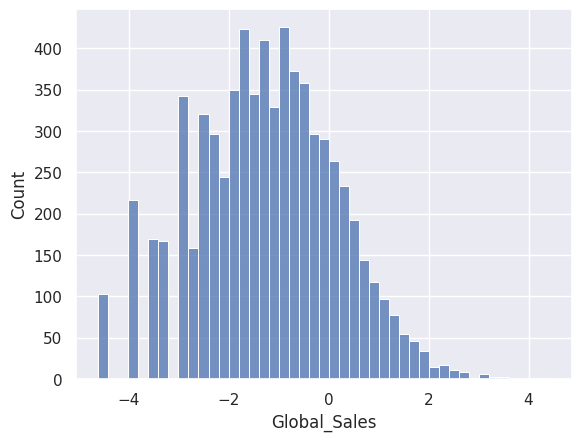

In [5]:
sns.histplot(np.log(df['Global_Sales']))

# Reconhecimento X Sucesso

In [6]:
df_rec_suc = df.copy()

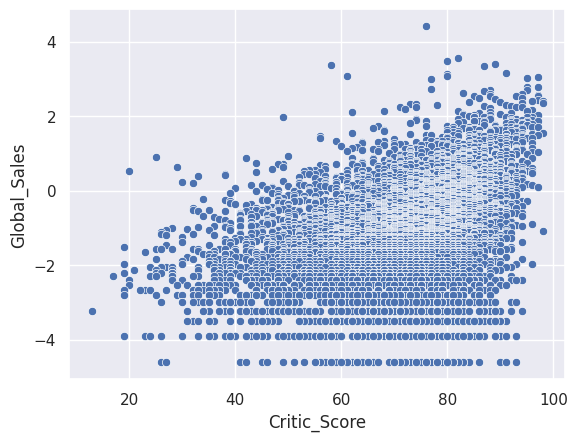

In [7]:
sns.scatterplot(x=df_rec_suc['Critic_Score'], y=np.log(df_rec_suc['Global_Sales']));

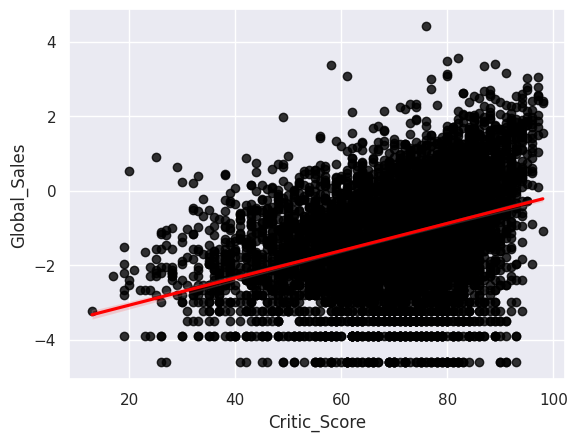

In [8]:
sns.regplot(x=df_rec_suc['Critic_Score'], y=np.log(df_rec_suc['Global_Sales']), scatter_kws={"color": "black"}, line_kws={"color": "red"});

In [9]:
result = reg.linear(data=df_rec_suc, formula='np.log(Global_Sales) ~ Critic_Score')

In [10]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.132
Model:                              OLS   Adj. R-squared:                  0.132
Method:                   Least Squares   F-statistic:                     1059.
Date:                  Tue, 01 Nov 2022   Prob (F-statistic):          3.06e-216
Time:                          03:27:00   Log-Likelihood:                -11682.
No. Observations:                  6943   AIC:                         2.337e+04
Df Residuals:                      6941   BIC:                         2.338e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.8081      0.081    -47.244      0.000      -3.966      -3.650
Critic_Score     0.0366      0.001     32.535      0.000       0.034       0.039
==============================================================================
Omnibus:                       70.342   Durbin-Watson:                   0.259
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.268
Skew:                          -0.246   Prob(JB):                     2.03e-16
Kurtosis:                       3.092   Cond. No.                         370.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
result.micro_summary()

variable,coefficient,std error,p-value
Critic_Score,0.036612,0.001125,0.000000


In [12]:
result.nano_summary()

+0.037 (0.001) ***


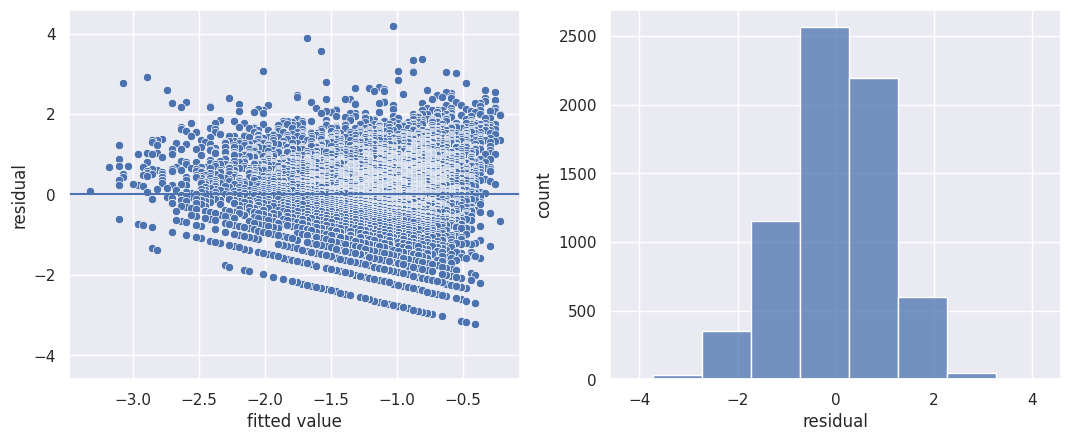

In [13]:
result.plot_residuals()

# Recepção X Sucesso

In [14]:
df_rep_suc = df.copy()

In [15]:
df_rep_suc.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E


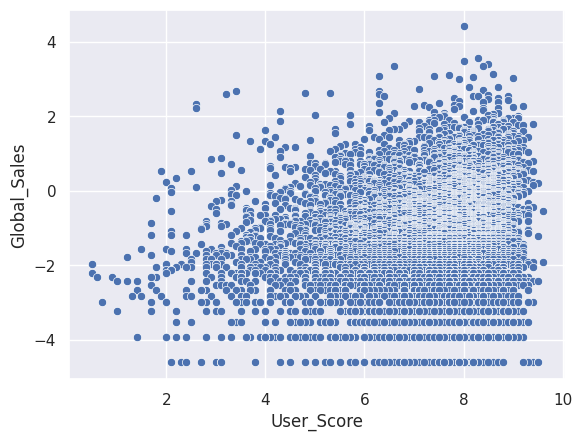

In [16]:
sns.scatterplot(x=df_rep_suc['User_Score'], y=np.log(df_rep_suc['Global_Sales']));

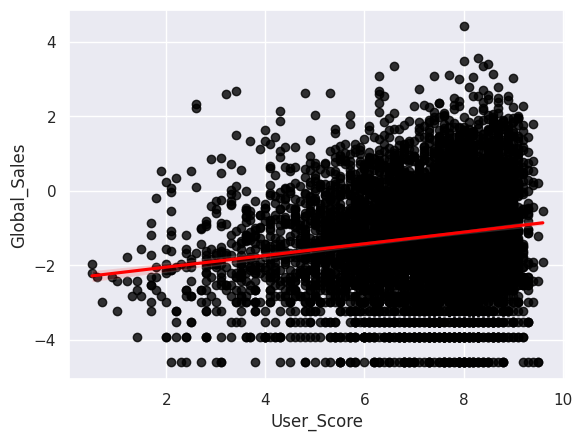

In [17]:
sns.regplot(x=df_rep_suc['User_Score'], y=np.log(df_rep_suc['Global_Sales']), scatter_kws={"color": "black"}, line_kws={"color": "red"});

In [18]:
result = reg.linear(data=df_rep_suc, formula='np.log(Global_Sales) ~ User_Score')

In [19]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.026
Model:                              OLS   Adj. R-squared:                  0.026
Method:                   Least Squares   F-statistic:                     185.7
Date:                  Tue, 01 Nov 2022   Prob (F-statistic):           9.51e-42
Time:                          03:27:29   Log-Likelihood:                -12083.
No. Observations:                  6943   AIC:                         2.417e+04
Df Residuals:                      6941   BIC:                         2.418e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3599      0.084    -28.037      0.000      -2.525      -2.195
User_Score     0.1565      0.011     13.627      0.000       0.134       0.179
==============================================================================
Omnibus:                        1.872   Durbin-Watson:                   0.053
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.853
Skew:                          -0.015   Prob(JB):                        0.396
Kurtosis:                       2.926   Cond. No.                         37.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
result.micro_summary()

variable,coefficient,std error,p-value
User_Score,0.156541,0.011488,0.000000


In [21]:
result.nano_summary()

+0.157 (0.011) ***


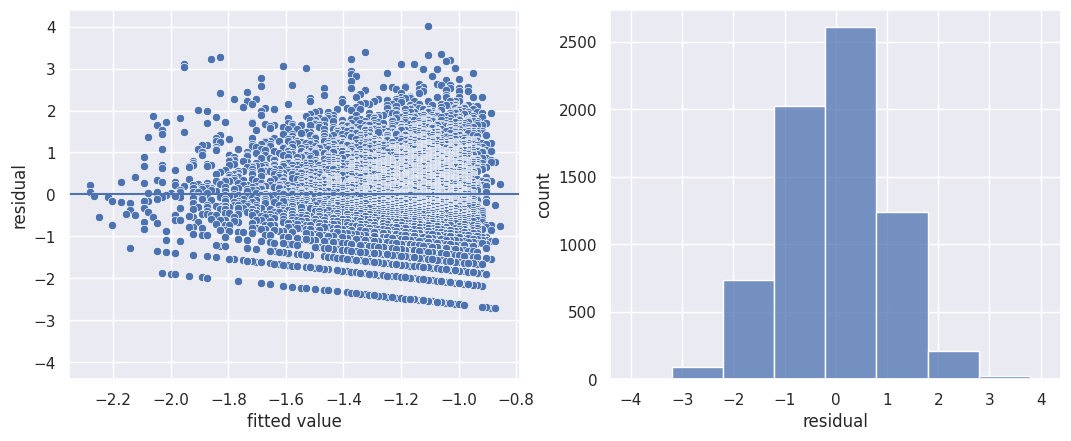

In [22]:
result.plot_residuals()

# Proximidade X Sucesso

In [23]:
df_pro_suc = df.copy()

In [24]:
g = gt_load("graph_closeness_component.net.gz")

In [25]:
data = gt_data(g)
data.drop('Games_released', axis=1, inplace=True)
data

,Publisher,closeness
id,,
Nintendo,Nintendo,0.657431
Microsoft Game Studios,Microsoft Game Studios,0.707317
Take-Two Interactive,Take-Two Interactive,0.966667
Sony Computer Entertainment,Sony Computer Entertainment,0.747851
Activision,Activision,1.000000
...,...,...
Lighthouse Interactive,Lighthouse Interactive,0.542620
CDV Software Entertainment,CDV Software Entertainment,0.542620
Encore,Encore,0.557692


In [26]:
df_pro_suc = pd.merge(df_pro_suc, data, on = "Publisher", how = "inner")
df_pro_suc.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,closeness
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E,0.657431
1,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,0.657431
2,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E,0.657431
3,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E,0.657431
4,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E,0.657431


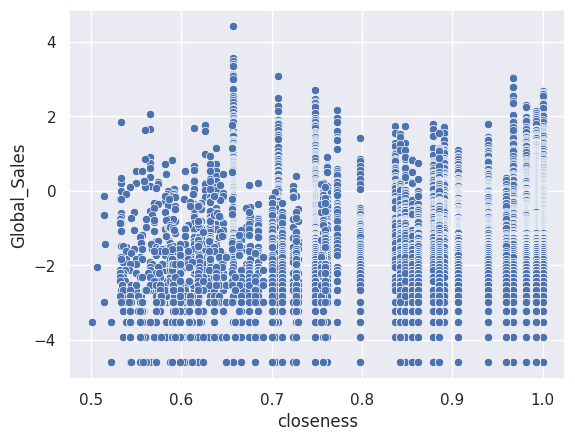

In [27]:
sns.scatterplot(x=df_pro_suc['closeness'], y=np.log(df_pro_suc['Global_Sales']));

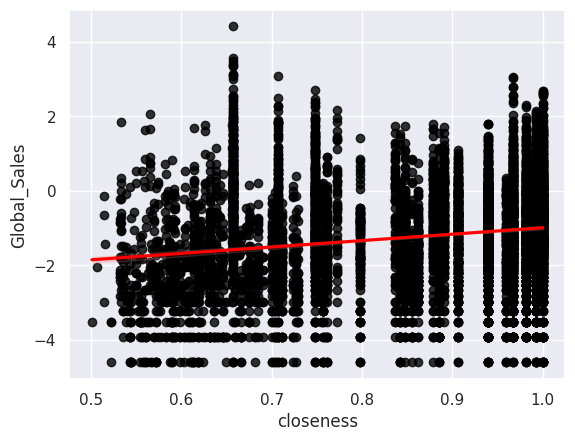

In [28]:
sns.regplot(x=df_pro_suc['closeness'], y=np.log(df_pro_suc['Global_Sales']), scatter_kws={"color": "black"}, line_kws={"color": "red"});

In [29]:
result = reg.linear(data=df_pro_suc, formula='np.log(Global_Sales) ~ closeness')

In [30]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.029
Model:                              OLS   Adj. R-squared:                  0.029
Method:                   Least Squares   F-statistic:                     208.5
Date:                  Tue, 01 Nov 2022   Prob (F-statistic):           1.38e-46
Time:                          03:28:13   Log-Likelihood:                -12066.
No. Observations:                  6941   AIC:                         2.414e+04
Df Residuals:                      6939   BIC:                         2.415e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7114      0.104    -26.172      0.000      -2.914      -2.508
closeness      1.7221      0.119     14.439      0.000       1.488       1.956
==============================================================================
Omnibus:                       10.746   Durbin-Watson:                   0.182
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.736
Skew:                           0.096   Prob(JB):                      0.00466
Kurtosis:                       3.025   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
result.micro_summary()

variable,coefficient,std error,p-value
closeness,1.722070,0.119265,0.000000


In [32]:
result.nano_summary()

+1.722 (0.119) ***


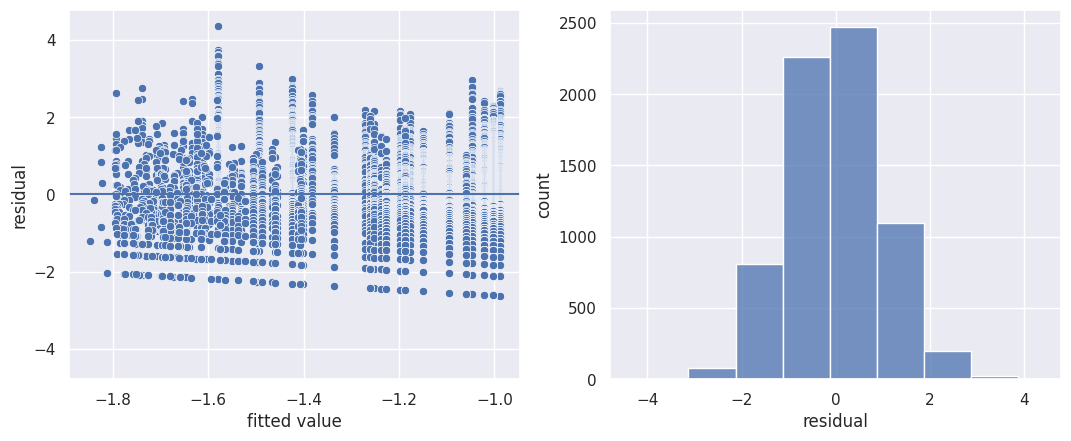

In [33]:
result.plot_residuals()

# Classificação etária X Sucesso

In [41]:
df_rat_suc = df.copy()
df_rat_suc.loc[df_rat_suc['Rating'] == 'E', 'Rating'] = 1
df_rat_suc.loc[df_rat_suc['Rating'] == 'E10+', 'Rating'] = 1
df_rat_suc.loc[df_rat_suc['Rating'] == 'K-A', 'Rating'] = 1
df_rat_suc.loc[df_rat_suc['Rating'] == 'M', 'Rating'] = 0
df_rat_suc.loc[df_rat_suc['Rating'] == 'T', 'Rating'] = 0
df_rat_suc.loc[df_rat_suc['Rating'] == 'AO', 'Rating'] = 0
df_rat_suc.loc[df_rat_suc['Rating'] == 'RP', 'Rating'] = 0
#df_rat_suc['Rating'] = df_rat_suc['Rating'].apply(pd.to_numeric)
df_rat_suc['Rating']

0        1
2        1
3        1
6        1
7        1
        ..
16667    1
16677    0
16696    0
16700    0
16706    1
Name: Rating, Length: 6943, dtype: object

/usr/local/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 83.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 78.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


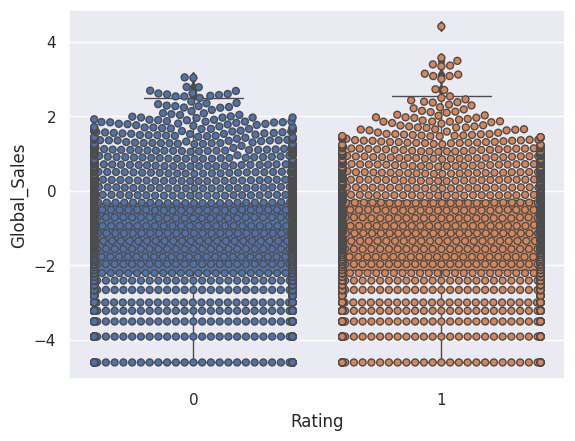

In [42]:
sns.boxplot(x=df_rat_suc['Rating'], y=np.log(df_rat_suc['Global_Sales']), linewidth=1)
sns.swarmplot(x=df_rat_suc['Rating'], y=np.log(df_rat_suc['Global_Sales']), linewidth=1);

In [44]:
result = reg.linear(data=df_rat_suc, formula='np.log(Global_Sales) ~ Rating')

In [45]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.002
Model:                              OLS   Adj. R-squared:                  0.002
Method:                   Least Squares   F-statistic:                     12.38
Date:                  Tue, 01 Nov 2022   Prob (F-statistic):           0.000437
Time:                          03:31:53   Log-Likelihood:                -12168.
No. Observations:                  6943   AIC:                         2.434e+04
Df Residuals:                      6941   BIC:                         2.435e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.2877      0.022    -57.447      0.000      -1.332      -1.244
Rating[T.1]     0.1187      0.034      3.519      0.000       0.053       0.185
==============================================================================
Omnibus:                        6.525   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                5.900
Skew:                           0.021   Prob(JB):                       0.0523
Kurtosis:                       2.864   Cond. No.                         2.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
result.nano_summary()

+0.119 (0.034) ***


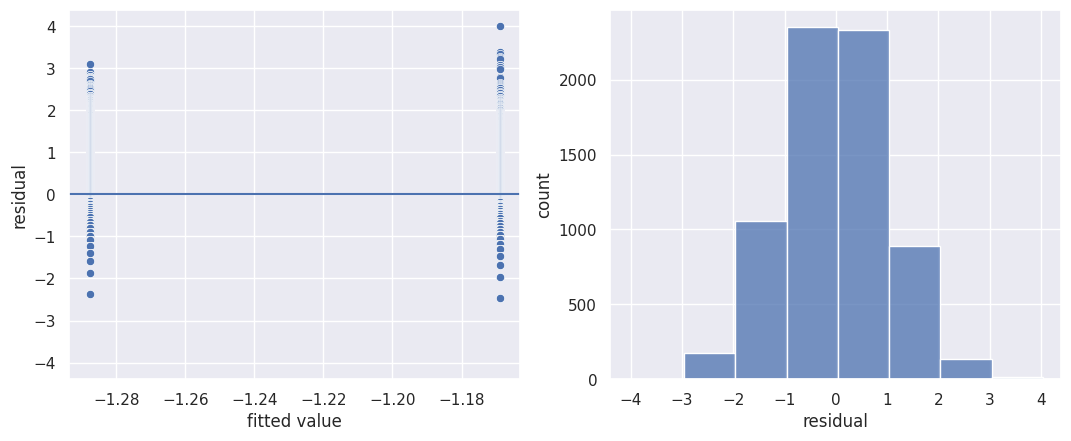

In [47]:
result.plot_residuals()

# Reconhecimento X Recepção

In [48]:
df_rec_rep = df.copy()

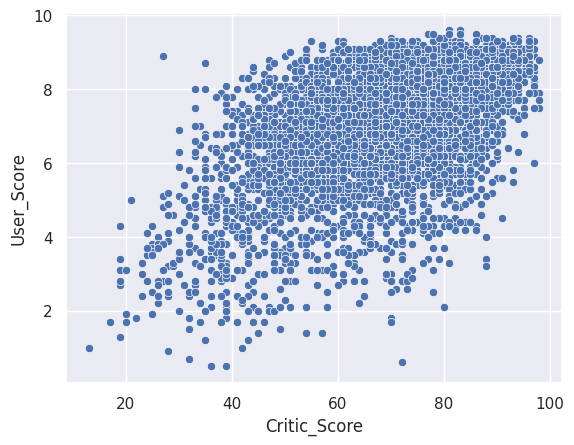

In [49]:
sns.scatterplot(x=df_rec_rep['Critic_Score'], y=df_rec_rep['User_Score']);

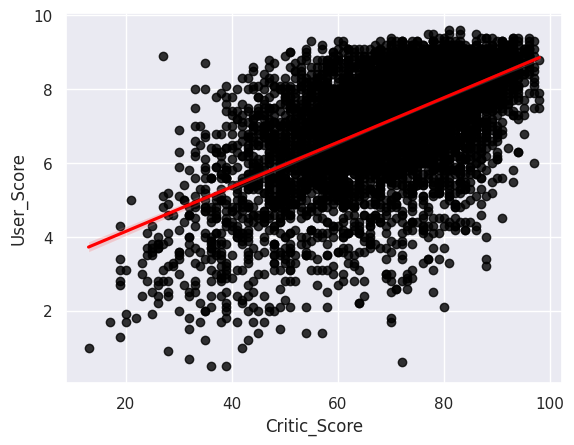

In [50]:
sns.regplot(x=df_rec_rep['Critic_Score'], y=df_rec_rep['User_Score'], scatter_kws={"color": "black"}, line_kws={"color": "red"});

In [51]:
result = reg.linear(data=df_rec_rep, formula='User_Score ~ Critic_Score')

In [52]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             User_Score   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     3551.
Date:                Tue, 01 Nov 2022   Prob (F-statistic):               0.00
Time:                        03:32:23   Log-Likelihood:                -10953.
No. Observations:                6943   AIC:                         2.191e+04
Df Residuals:                    6941   BIC:                         2.192e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.9414      0.073     40.528      0.000       2.799       3.084
Critic_Score     0.0604      0.001     59.589      0.000       0.058       0.062
==============================================================================
Omnibus:                     1016.843   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1894.787
Skew:                          -0.930   Prob(JB):                         0.00
Kurtosis:                       4.759   Cond. No.                         370.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
result.nano_summary()

+0.060 (0.001) ***


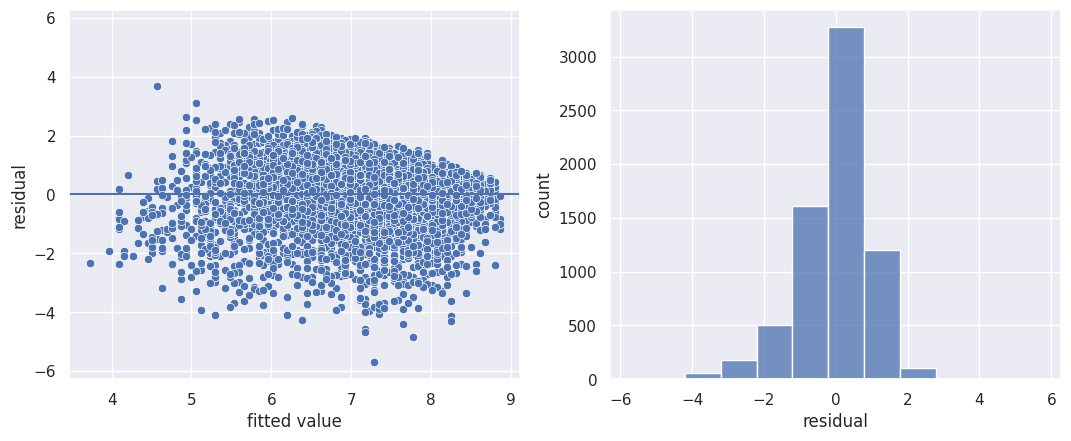

In [54]:
result.plot_residuals()

# Tudo junto X Sucesso

In [55]:
g = gt_load("graph_closeness_component.net.gz")

In [56]:
data = gt_data(g)
data.drop('Games_released', axis=1, inplace=True)
data

,Publisher,closeness
id,,
Nintendo,Nintendo,0.657431
Microsoft Game Studios,Microsoft Game Studios,0.707317
Take-Two Interactive,Take-Two Interactive,0.966667
Sony Computer Entertainment,Sony Computer Entertainment,0.747851
Activision,Activision,1.000000
...,...,...
Lighthouse Interactive,Lighthouse Interactive,0.542620
CDV Software Entertainment,CDV Software Entertainment,0.542620
Encore,Encore,0.557692


In [57]:
df_tud_suc = df.copy()
df_tud_suc.loc[df_tud_suc['Rating'] == 'E', 'Rating'] = 1
df_tud_suc.loc[df_tud_suc['Rating'] == 'E10+', 'Rating'] = 1
df_tud_suc.loc[df_tud_suc['Rating'] == 'K-A', 'Rating'] = 1
df_tud_suc.loc[df_tud_suc['Rating'] == 'M', 'Rating'] = 0
df_tud_suc.loc[df_tud_suc['Rating'] == 'T', 'Rating'] = 0
df_tud_suc.loc[df_tud_suc['Rating'] == 'AO', 'Rating'] = 0
df_tud_suc.loc[df_tud_suc['Rating'] == 'RP', 'Rating'] = 0
df_tud_suc['Rating'] = df_tud_suc['Rating'].apply(pd.to_numeric)
df_tud_suc = pd.merge(df_tud_suc, data, on = "Publisher", how = "inner")
df_tud_suc.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,closeness
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,1,0.657431
1,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,1,0.657431
2,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,1,0.657431
3,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,1,0.657431
4,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,1,0.657431


In [58]:
result = reg.linear(data=df_tud_suc, formula='np.log(Global_Sales) ~ User_Score + Critic_Score + closeness + Rating')

In [59]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.154
Model:                              OLS   Adj. R-squared:                  0.154
Method:                   Least Squares   F-statistic:                     315.9
Date:                  Tue, 01 Nov 2022   Prob (F-statistic):          4.51e-250
Time:                          03:32:38   Log-Likelihood:                -11588.
No. Observations:                  6941   AIC:                         2.319e+04
Df Residuals:                      6936   BIC:                         2.322e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.7192      0.130    -36.366      0.000      -4.974      -4.465
User_Score      -0.0513      0.013     -3.860      0.000      -0.077      -0.025
Critic_Score     0.0384      0.001     27.755      0.000       0.036       0.041
closeness        1.2784      0.113     11.317      0.000       1.057       1.500
Rating           0.1269      0.031      4.077      0.000       0.066       0.188
==============================================================================
Omnibus:                       49.940   Durbin-Watson:                   0.404
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.538
Skew:                          -0.194   Prob(JB):                     6.44e-12
Kurtosis:                       3.165   Cond. No.                         746.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
result.nano_summary()

-0.051 (0.013) ***
+0.038 (0.001) ***
+1.278 (0.113) ***
+0.127 (0.031) ***


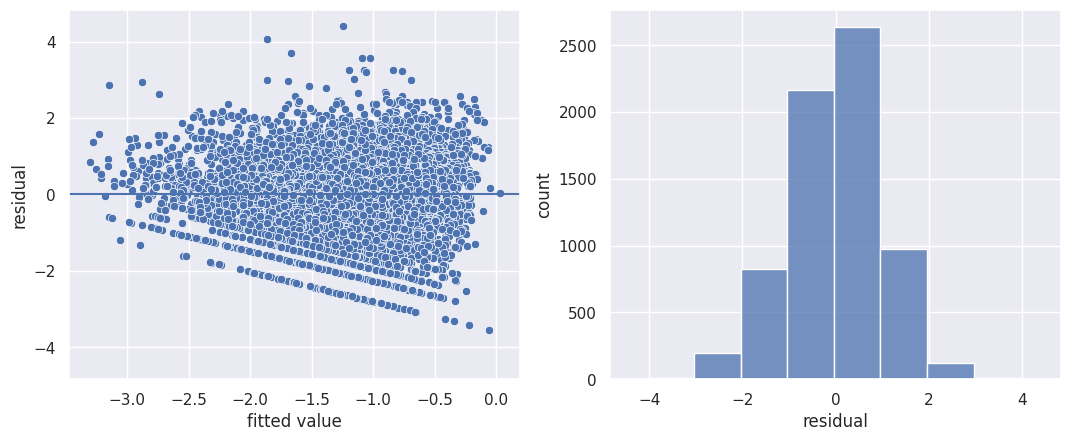

In [61]:
result.plot_residuals()